# Set-up

In [1]:
import wrds
import pandas as pd
import numpy as np
import os
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Get the current working directory
script_dir = os.getcwd()

# Set the working directory to the current script's directory (which in this case is already the working directory)
os.chdir(script_dir)

print(f"Working directory is set to: {script_dir}")

# Connect to WRDS
db = wrds.Connection(wrds_username='zrsong')

# Define the start and end dates
start_date = '2010-01-01'
end_date = '2024-06-30'

Working directory is set to: /Users/zrsong/Dropbox (MIT)/MPS_Interest Deductibility and Debt Contracting/4. Code
Loading library list...
Done


In [2]:
overleaf_dir = "/Users/zrsong/Dropbox (MIT)/Apps/Overleaf/M&A Debt"

# Compustat / CRSP

In [3]:
fund_table = 'funda'

varlist = ['conm', 'tic', 'cusip','fyear', 'fyr', 'at','capx', 'ceq', 'cogs', 'csho', 'dlc', 'dlcch','dltt', 'dp', 'ib', 'itcb', 
           'lt', 'mib', 'naicsh', 'ni', 'prstkcc', 'pstk', 'pstkl', 'pstkrv', 're', 'revt', 'sale', 'ebitda', 'dpc', 'oiadp', 'oibdp',
           'seq', 'sich', 'txdb', 'txdi', 'txditc', 'wcapch', 'xint', 'xlr', 'xrd', 'xsga', 'ppegt', 'xrd', 'ebit', 'aqc',
           'act', 'che', 'dltis', 'dltr', 'dvc', 'idit', 'intan', 'lct', 'dclo', 'oancf', 'pi', 'pifo', 'ppent', 'prcc_f', 'tlcf', 'txfo']

query = """SELECT gvkey, datadate, {}
           FROM comp.{}
           WHERE datafmt = 'STD'
           AND popsrc = 'D'
           AND indfmt = 'INDL'
           AND consol = 'C'
           AND fyear>=2009;""".format(", ".join(varlist), fund_table)

compa = db.raw_sql(query, date_cols=['datadate'])

del(fund_table, varlist, query)

In [4]:
# Import SIC codes from comp.company
sic_table = 'company'
query = "SELECT gvkey, sic, ipodate FROM comp.company"
sic_codes = db.raw_sql(query)

# Merge SIC codes back to compa dataframe
compa = compa.merge(sic_codes, how='left', on='gvkey')

In [5]:
# all colnames of compa
# check if sic exists
# for each gvkey fyear, keep the one with the highest at
compa = compa.sort_values(['gvkey', 'fyear', 'at'], ascending=[True, True, False])
compa = compa.drop_duplicates(subset=['gvkey', 'fyear'], keep='first')

# drop if at is missing
compa = compa.dropna(subset=['at'])

# drop if xint is missing or negative
compa = compa.dropna(subset=['xint'])
compa = compa[compa['xint'] > 0]

# missing values of ebitda (due to missing dp/oiabp)
compa['ebitda'] = compa['ebitda'].fillna(compa['ebit'] + compa['dp'])
# replace ebitda = pi + xint - idit + dp if ebitda is still missing
compa['ebitda'] = compa['ebitda'].fillna(compa['pi'] + compa['xint'] - compa['idit'] + compa['dp'])
# replace ebit = pi + xint - idit if ebit is still missing
compa['ebit'] = compa['ebit'].fillna(compa['pi'] + compa['xint'] - compa['idit'])

# drop if ebitda is missing
compa = compa.dropna(subset=['ebitda'])

# Remove duplicate columns
compa = compa.loc[:, ~compa.columns.duplicated()]

compa['dclo'] = compa['dclo'].fillna(0)
compa['idit'] = compa['idit'].fillna(0)

In [6]:
# Debt
compa['debt'] = compa['dltt'] + compa['dlc'] - compa['dclo']

# Dividend_payer
compa['dividend_payer'] = (compa['dvc'] > 0).astype(int)

# Excess_interest 30% rule
compa['excess_interest_30'] = (compa['xint'] > compa['idit'] + 0.3 * compa['ebitda'].clip(lower=0)).astype(int)
# Excess_interest loss rule
compa['excess_interest_loss'] = (compa['pi'] < 0).astype(int)

# Financial deficit
compa['financial_deficit'] = (compa['oancf'] - compa['capx'] - compa['dvc'] < 0).astype(int)

# Immediate_depletion
compa['immediate_depletion'] = (compa['che'] + compa['oancf'] - compa['capx'] - compa['dvc'] < 0).astype(int)

# Interest expense loss rule
compa['interest_expense_loss_rule'] = np.where(
    (compa['pi'] + compa['xint']) <= 0,
    compa['xint'],
    np.where(
        compa['xint'] > (compa['pi'] + compa['xint']),
        compa['xint'] - (compa['pi'] + compa['xint']),
        0
    )
)

# Interest expense 30% rule
compa['interest_expense_30_rule'] = compa['xint'] - compa['interest_expense_loss_rule'] - (compa['idit'] +  0.3 * compa['ebitda'].clip(lower=0))
# clip lower bound to 0
compa['interest_expense_30_rule'] = compa['interest_expense_30_rule'].clip(lower=0)

# Interest expense not excess
compa['interest_expense_not_excess'] = compa['xint'] - compa['interest_expense_loss_rule'] - compa['interest_expense_30_rule']

# Interest expense total excess
compa['interest_expense_total_excess'] = compa['xint'] - (compa['idit'] + 0.3 * compa['ebitda'].clip(lower=0))
# clip lower bound to 0
compa['interest_expense_total_excess'] = compa['interest_expense_total_excess'].clip(lower=0)

# Investment
compa['investment'] = compa['aqc'] + compa['capx'] + compa['xrd']

# Loss before interest expense
compa['loss_before_interest_expense'] = ((compa['pi'] + compa['idit']) < 0).astype(int)

# Market to book
compa['market_to_book'] = (compa['debt'] + compa['pstk'] + (compa['prcc_f'] * compa['csho'])) / compa['at']

# MNC (indicator = 1 if pifo or txfo not missing or zero)
compa['mnc'] = ((compa['pifo'] != 0) | (compa['txfo'] != 0)).astype(int)

# Net interest
compa['net_interest'] = compa['xint'] - compa['idit']

# NOL 
compa['nol'] = (compa['tlcf'] > 0).astype(int)

# Sales growth
compa['sales_growth'] = (compa['sale'] - compa['sale'].shift(1)) / compa['sale'].shift(1)
# change sales growth to 0 if inf
compa['sales_growth'] = compa['sales_growth'].replace([np.inf, -np.inf], 0)
# clip sales growth to -1 and 1
compa['sales_growth'] = compa['sales_growth'].clip(-1, 1)

# Z-score
compa['z_score'] = (3.3 * compa['pi'] + 1.0 * compa['sale'] + 1.4 * compa['re'] + 1.2 * (compa['act'] - compa['lct'])) / compa['at']

# Delta_DCF
compa['delta_dcf'] = compa['dltis'] - compa['dltr']

In [7]:
# Define the variables to be imported
crsp_vars = ['cusip', 'permco', 'permno', 'date', 'ret', 'vol', 'shrout', 'prc']

# Define the query to get the annual returns of North American firms
crsp_query = f"""
    SELECT {', '.join(crsp_vars)}
    FROM crsp.msf
    WHERE date >= '{start_date}' AND date <= '{end_date}'
"""

# Execute the query and fetch the data
crspm = db.raw_sql(crsp_query, date_cols=['date'])

# Display the first few rows of the dataframe
print(crspm.head())

# header information from the CRSP file
crsp_hdr_query = """
    SELECT *
    FROM crsp.dsfhdr
"""

# Execute the query and fetch the data
crsp_hdr = db.raw_sql(crsp_hdr_query, date_cols=['date'])

# Display the first few rows of the dataframe
print(crsp_hdr.head())

      cusip  permco  permno       date       ret      vol   shrout    prc
0  36720410    7953   10001 2010-01-29 -0.018932   3104.0   4361.0  10.06
1  05978R10    7954   10002 2010-01-29  0.365854   7547.0  17634.0   3.92
2  00103110    7975   10025 2010-01-29 -0.088036   8653.0   6849.0  34.91
3  46603210    7976   10026 2010-01-29  0.046296  17859.0  18392.0  41.81
4  29402E10    7978   10028 2010-01-29 -0.028369    739.0   9834.0   1.37
   permno  permco  hshrcd  dlstcd    hcusip htick  \
0   10000    7952      10     560  68391610  None   
1   10001    7953      11     233  36720410  None   
2   10002    7954      11     231  05978R10  None   
3   10003    7957      11     231  39031810  None   
4   10004    7960      10     575  18906310  None   

                         hcomnam htsymbol  hnaics hprimexc  ...      begvol  \
0      OPTIMUM MANUFACTURING INC    OMFGA    None        Q  ...  1986-01-07   
1                GAS NATURAL INC     EGAS  221210        A  ...  1986-01-09   


In [8]:
# merge crspm and crsp_hdr with permno
crspm = crspm.merge(crsp_hdr[['permno', 'dlstcd']], on='permno', how='left')

# sort by permno date
crspm = crspm.sort_values(['permno', 'date'])

# Aggregate the data by permno and year and calculate the buy and hold return over the year as well as the volatility
crspm['year'] = crspm['date'].dt.year

# Display the first few rows of the dataframe
print(crspm.head())

          cusip  permco  permno       date       ret     vol  shrout      prc  \
0      36720410    7953   10001 2010-01-29 -0.018932  3104.0  4361.0  10.0600   
6744   36720410    7953   10001 2010-02-26 -0.000656  1510.0  4361.0  10.0084   
13488  36720410    7953   10001 2010-03-31  0.020643  2283.0  4361.0  10.1700   
20259  36720410    7953   10001 2010-04-30  0.124385  3350.0  6070.0  11.3900   
27016  36720410    7953   10001 2010-05-28  0.004829  3451.0  6071.0  11.4000   

       dlstcd  year  
0         233  2010  
6744      233  2010  
13488     233  2010  
20259     233  2010  
27016     233  2010  


In [9]:
std_ret = crspm.groupby(['permno', 'year'])['ret'].std().reset_index()
buy_and_hold_return = crspm.groupby(['permno', 'year'])['ret'].apply(lambda x: (1 + x).prod() - 1).reset_index()
# merge the buy and hold return and the volatility to the crspm dataframe
crspm = crspm.merge(buy_and_hold_return, on=['permno', 'year'], suffixes=('', '_buy_and_hold'))
crspm = crspm.merge(std_ret, on=['permno', 'year'], suffixes=('', '_vol'))

# aggregate to permno and year level (keep ret_buy_and_hold and ret_vol and dlstcd)
crspa = crspm.groupby(['permno', 'year']).agg({
    'ret_buy_and_hold': 'first',
    'ret_vol': 'first',
    'dlstcd': 'first'
}).reset_index()

In [10]:
# Compustat/CRSP Link Table
ccm_query = """
    SELECT gvkey, lpermno, linktype, linkprim, linkdt, linkenddt
    FROM crsp.ccmxpf_linktable
"""

# Execute the query and fetch the data
ccm = db.raw_sql(ccm_query, date_cols=['linkdt', 'linkenddt'])

# Display the first few rows of the dataframe
print(ccm.head())

# merge crspa and ccm
crspac = crspa.merge(ccm, left_on='permno', right_on='lpermno', how='left')

# keep only the rows where the link date is before the year and the link end date is after the year
# change linkenddt to 2024-12-31 if it is NaT
crspac['linkenddt'] = crspac['linkenddt'].fillna(pd.Timestamp('2024-12-31'))
crspac = crspac[(crspac['year'] >= crspac['linkdt'].dt.year) & (crspac['year'] <= crspac['linkenddt'].dt.year)]

# merge crspac with compa on gvkey (keep everything)
comp_crspa_merged = compa.merge(crspac, on='gvkey', how='inner')

    gvkey  lpermno linktype linkprim     linkdt  linkenddt
0  001000      NaN       NU        C 1961-01-01 1970-09-29
1  001000      NaN       NU        P 1970-09-30 1970-11-12
2  001000  25881.0       LU        P 1970-11-13 1978-06-30
3  001001      NaN       NU        C 1978-01-01 1983-09-19
4  001001  10015.0       LU        P 1983-09-20 1986-07-31


In [11]:
# change gvkey to int
comp_crspa_merged['gvkey'] = comp_crspa_merged['gvkey'].astype(int)

In [12]:
# output csv. format
comp_crspa_merged.to_csv("../3. Data/Processed/comp_crspa_merged.csv", index=False)

# Quarterly Compustat

In [525]:
# # Quarterly Compustat data
# fund_table = 'fundq'
# varlist = ['gvkey', 'conm', 'tic', 'cusip','fyearq', 'fqtr', 'fyr', 'atq','capxy', 'ceqq', 'cogsq', 
#            'cshoq', 'dlcq', 'dlcchy','dlttq', 'dpq', 'ibq', 'itccy', 'fic', 'pstkrq',
#            'ltq', 'mibq', 'niq', 'prstkccy', 'pstkq', 'req', 'revtq', 'saleq',
#            'seqq', 'txdbq', 'txdiq', 'txditcq', 'wcapchy', 'xinty', 'xrdq', 'xrdy', 'xsgaq',
#            'mkvaltq', 'epspxq', 'epsfxq', 'ajexq', 'prccq', 'oancfy', 'ivncfy', 'rdq', 'ppegtq', 'ppentq']
# # Join the list into a comma-separated string
# varlist_str = ", ".join(varlist)
# # use the varlist above to query quarterly compustat data (don't use join(varlist) as it will return a string)
# query = f"""
#     SELECT {varlist_str}
#     FROM comp_na_daily_all.{fund_table}
#     WHERE datadate >= '{start_date}' AND datadate <= '{end_date}'
# """
# compq = db.raw_sql(query)
# # How to deal with duplicates? Keep last available entry (datadate)
# compq.dropna(subset=['fyearq', 'fqtr'], inplace=True)
# compq.sort_values(['gvkey','fyearq', 'fqtr', 'atq'], inplace=True)
# compq = compq[~compq.duplicated(['gvkey', 'fyearq', 'fqtr'], keep='last')]
# duplicate_columns = compq.columns[compq.columns.duplicated()]
# print("Duplicate columns:", duplicate_columns)
# # Calculating BE
# # Shareholder Equity
# compq['se'] = compq['seqq']
# # Uses Common Equity (ceq) + Preferred Stock (pstk) if SEQ is missing:
# compq['se'] = compq['se'].fillna(compq['ceqq'] + compq['pstkq'])
# # Uses Total Assets (at) - Liabilities (lt) + Minority Interest (mib, if available), if others are missing
# compq['se'] = compq['se'].fillna(compq['atq'] - compq['ltq'] + compq['mibq'].fillna(0))
# # Preferred Stock
# # Preferred Stock (Redemption Value)
# compq['ps'] = compq['pstkrq']
# # Uses Preferred Stock (Liquidating Value (pstkl)) if Preferred Stock (Redemption Value) is missing (pstkl doesnt' exist for quarterly data)
# # compq['ps'] = compq['ps'].fillna(compq['pstkl'])
# # Uses Preferred Stock (Carrying Value (pstk)) if others are missing
# compq['ps'] = compq['ps'].fillna(compq['pstkq'])
# # Deferred Taxes
# # Uses Deferred Taxes and Investment Tax Credit (txditc)
# compq['dt'] = compq['txditcq']
# # This was Novy-Marx old legacy code. We drop this part to be in accordance with Ken French.
# # Uses Deferred Taxes and Investment Tax Credit(txdb) + Investment Tax Credit (Balance Sheet) (itcb) if txditc is missing (itcb (Investment Tax Credit (Balance Sheet)) doesn't exist for quarterly data)
# compq['dt'] = compq['dt'].fillna(compq['txdbq'].fillna(0))
# # If all measures are missing, set to missing
# compq.loc[pd.isnull(compq['txditcq']) & pd.isnull(compq['txdbq']), 'dt'] = np.nan
# # Book Equity
# # Book Equity (BE) = Share Equity (se) - Prefered Stocks (ps) + Deferred Taxes (dt)
# compq['be'] = (compq['se']  # shareholder equity must be available, otherwise BE is missing
#                - compq['ps']  # preferred stock must be available, otherwise BE is missing
#                + compq['dt'].fillna(0))  # add deferred taxes if available
#                #- compa['prba'].fillna(0))  # subtract postretirement benefit assets if available
# # COST = COGS + XSGA + XINT 
# compq['cost'] = compq[['cogsq', 'xsgaq', 'xinty']].sum(axis=1, skipna=True)
# compq.loc[compq[['cogsq', 'xsgaq', 'xinty']].isnull().all(axis=1), 'cost'] = np.nan
# # OP = SALE - COST    
# compq['op'] = compq['saleq']-compq['cost']
# # output csv. format
# compq.to_csv("../Data/Raw/compustat_quarterly.csv", index=False)

# Dealscan

In [526]:
# Query the dealscan syndicated loan data
#query = f"""
#    SELECT *
#    FROM tr_dealscan.dealscan
#    WHERE deal_active_date >= '{start_date}' AND deal_active_date <= '{end_date}'
#"""

# Execute the query and fetch the data
#dealscan_data = db.raw_sql(query)
# Save the data to a CSV file
#dealscan_data.to_csv('../Data/Raw/dealscan_data.csv', index=False)

In [13]:
# import dealscan data 
dealscan_data = pd.read_csv("../3. Data/Raw/dealscan_data.csv")

/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_34597/4219223696.py:2: DtypeWarning: Columns (26,42,46,50,65,85,103,106,107,108,109,112,113,122,127,130,138,139,140,142,146,150,151,152,155,156,157,158,159,160,161,162,163,164,200,202) have mixed types. Specify dtype option on import or set low_memory=False.
  dealscan_data = pd.read_csv("../3. Data/Raw/dealscan_data.csv")


In [14]:
# Convert deal_active_date to datetime if it's not already
dealscan_data['deal_active_date'] = pd.to_datetime(dealscan_data['deal_active_date'])

# Filter the dataframe
dealscan_data = dealscan_data[dealscan_data['deal_active_date'] >= '2010-01-01']

# keep only county == "United States"
dealscan_data = dealscan_data[dealscan_data['country'] == 'United States']

# generate leveraged = 1 if the text "Leveraged" appears in market_segment
dealscan_data['leveraged'] = dealscan_data['market_segment'].str.contains("Leveraged", case=False, na=False).astype(int)

# generate year from deal_active_date
dealscan_data['year'] = dealscan_data['deal_active_date'].dt.year

In [15]:
def plot_dealcount(dealscan_data, label_name):
    # aggregate by lpc_tranche_id and tranche_permid
    collapsed_ds = dealscan_data.groupby(['lpc_deal_id']).agg({
        'deal_permid': 'first',
        'deal_active_date': 'min',
        'borrower_name': 'first',
        'borrower_id': 'first',
        'state_province': 'first',
        'country': 'first',
        'zip': 'first',
        'city': 'first',
        'sic_code': 'first',
        'sponsor': 'first',
        'lead_arranger': 'first',
        'number_of_lenders': 'first',
        'deal_amount': 'first',
        'deal_amount_converted': 'first',
        'deal_purpose': 'first',
        'deal_amended': 'first',
        'market_segment': 'first',
        'seniority_type': 'first',
        'secured': 'first',
        'margin_bps': 'first',
        'leveraged': 'first',
        'year': 'first',
    }).reset_index()

    # sort by lpc_deal_id and deal_active_date
    collapsed_ds = collapsed_ds.sort_values(['lpc_deal_id', 'deal_active_date'])

    # collapse dataset down by year leveraged
    deal_count = collapsed_ds.groupby(['year', 'leveraged']).agg({
        'lpc_deal_id': 'count',
    }).reset_index()

    # Assuming 'deal_count' contains the data
    sns.barplot(x='year', y='lpc_deal_id', hue='leveraged', data=deal_count, errorbar=None, alpha=1)

    # Add labels and a title
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Deal Count', fontsize=12)
    plt.title(f'LPC Deal Count by Year and Leveraged Status: {label_name}', fontsize=14)

    # Rotate x-axis labels by 45 degrees
    plt.xticks(rotation=45)

    # Remove top and right borders
    sns.despine()

    # Show the plot
    plt.tight_layout()

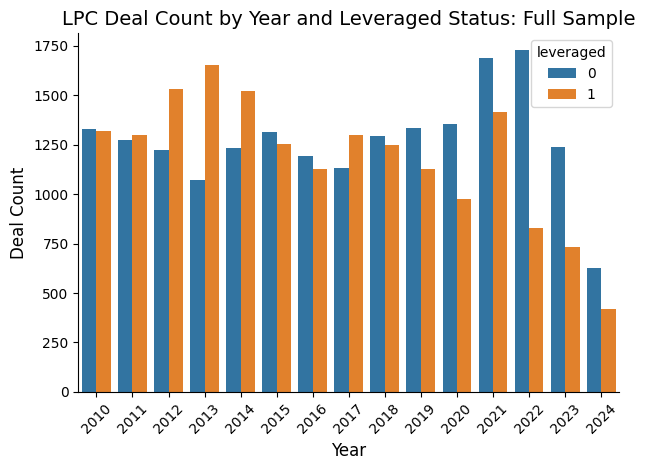

In [16]:
plot_dealcount(dealscan_data, 'Full Sample')
# save the plot as pdf
plt.savefig(os.path.join(overleaf_dir, 'Figures/ds_count_full_sample.png'))

## Split by term loan and revolver

In [17]:
# generate term_loan = 1 if the text "Term Loan" appears in tranche type
dealscan_data['term_loan'] = dealscan_data['tranche_type'].str.contains("Term Loan", case=False, na=False).astype(int)
dealscan_data['revolver'] = dealscan_data['tranche_type'].str.contains("Revolver", case=False, na=False).astype(int)

# keep only term_loan or revolver
dealscan_data = dealscan_data[(dealscan_data['term_loan'] == 1) | (dealscan_data['revolver'] == 1)]

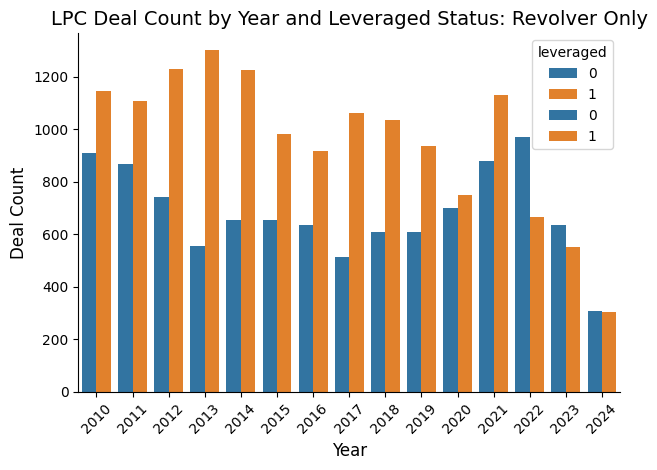

In [18]:
# plots for term_loan only
dealscan_data_term_loan = dealscan_data[dealscan_data['term_loan'] == 1]
plot_dealcount(dealscan_data_term_loan, 'Term Loan Only')
# save the plot as pdf
plt.savefig(os.path.join(overleaf_dir, 'Figures/ds_count_term_loan.png'))

# plots for revolver only
dealscan_data_revolver = dealscan_data[dealscan_data['revolver'] == 1]
plot_dealcount(dealscan_data_revolver, 'Revolver Only')
# save the plot as pdf
plt.savefig(os.path.join(overleaf_dir, 'Figures/ds_count_revolver.png'))

## Merge with Compustat/CRSP

In [20]:
dealscan_new_legacy_link = pd.read_excel('../3. Data/Raw/WRDS_to_LoanConnector_IDs.xlsx')

# Rename columns to lpc_deal_id, packageid, lpc_tranche_id, facilityid
dealscan_new_legacy_link.columns = ['lpc_deal_id', 'packageid', 'lpc_tranche_id', 'facilityid']

# Identify duplicates in the combination of 'lpc_deal_id' and 'lpc_tranche_id'
dealscan_new_legacy_link['dup'] = dealscan_new_legacy_link.duplicated(subset=['lpc_deal_id', 'lpc_tranche_id'], keep=False).astype(int)

# Drop rows where duplicates exist (i.e., 'dup' != 0)
dealscan_new_legacy_link = dealscan_new_legacy_link[dealscan_new_legacy_link['dup'] == 0]

# Drop the 'dup' column (no longer needed)
dealscan_new_legacy_link = dealscan_new_legacy_link.drop(columns=['dup'])

In [21]:
# merge with dealscan_data on lpc_deal_id and lpc_tranche_id
dealscan_merged = dealscan_data.merge(dealscan_new_legacy_link, on=['lpc_deal_id', 'lpc_tranche_id'], how='inner')

In [23]:
dealscan_compustat_link = pd.read_excel('../3. Data/Raw/Dealscan-Compustat_Linking_Database012024.xlsx', sheet_name = 'links')

dealscan_merged = dealscan_merged.merge(dealscan_compustat_link, on='facilityid', how='inner')

# merge gvkey with compustat annual data for now 
dealscan_merged['fyear'] = dealscan_merged['year'] - 1 # use the previous fiscal year financials 
dealscan_comp_crspa_merged = dealscan_merged.merge(comp_crspa_merged, on=['gvkey', 'fyear'], how='inner')

In [24]:
# calculate the interest coverage ratio
dealscan_comp_crspa_merged['interest_expense_by_ebitda'] = dealscan_comp_crspa_merged['xint'] / dealscan_comp_crspa_merged['ebitda']
# describe the interest coverage ratio
dealscan_comp_crspa_merged['interest_expense_by_ebitda'].describe()

count    898075.000000
mean          0.156449
std           3.512410
min        -360.132450
25%           0.064984
50%           0.140852
75%           0.243848
max          89.258065
Name: interest_expense_by_ebitda, dtype: float64

## Nbr of Fin Covenants, perf pricing indicator, sweep indicator

In [25]:
collapsed_ds = dealscan_data.groupby(['lpc_deal_id']).agg({
    'deal_permid': 'first',
    'deal_active_date': 'min',
    'borrower_name': 'first',
    'borrower_id': 'first',
    'state_province': 'first',
    'country': 'first',
    'zip': 'first',
    'city': 'first',
    'sic_code': 'first',
    'sponsor': 'first',
    'lead_arranger': 'first',
    'number_of_lenders': 'first',
    'deal_amount': 'first',
    'deal_amount_converted': 'first',
    'deal_purpose': 'first',
    'deal_amended': 'first',
    'market_segment': 'first',
    'seniority_type': 'first',
    'secured': 'first',
    'margin_bps': 'first',
    'leveraged': 'first',
    'year': 'first',
    'covenants': 'first', 
    'all_covenants_financial': 'first',
    'performance_pricing': 'first',
    'excess_cf_sweep': 'first',
    'asset_sales_sweep': 'first',
    'debt_issue_sweep': 'first',
    'equity_issue_sweep': 'first',
    'insurance_proceeds_sweep': 'first',
}).reset_index()

In [26]:
# generate num_fin_cov that is the number of commas in all_covenants_financial + 1
collapsed_ds['num_fin_cov'] = collapsed_ds['all_covenants_financial'].str.count(',') + 1
# generate perf_pricing dummy that is 1 if performance_pricing is not empty
collapsed_ds['perf_pricing_dummy'] = collapsed_ds['performance_pricing'].notnull().astype(int)
# generate sweep dummy that is 1 if any of the sweep covenants is not empty
sweep_cols = ['excess_cf_sweep', 'asset_sales_sweep', 'debt_issue_sweep', 'equity_issue_sweep', 'insurance_proceeds_sweep']
collapsed_ds['sweep_dummy'] = collapsed_ds[sweep_cols].notnull().any(axis=1).astype(int)

# Calculate the average number of num_fin_cov over years
avg_num_fin_cov = collapsed_ds.groupby('year')['num_fin_cov'].mean().reset_index()
# Calculate the frequency of perf_pricing_dummy and sweep_dummy over years
freq_perf_pricing = collapsed_ds.groupby('year')['perf_pricing_dummy'].mean().reset_index()
freq_sweep = collapsed_ds.groupby('year')['sweep_dummy'].mean().reset_index()

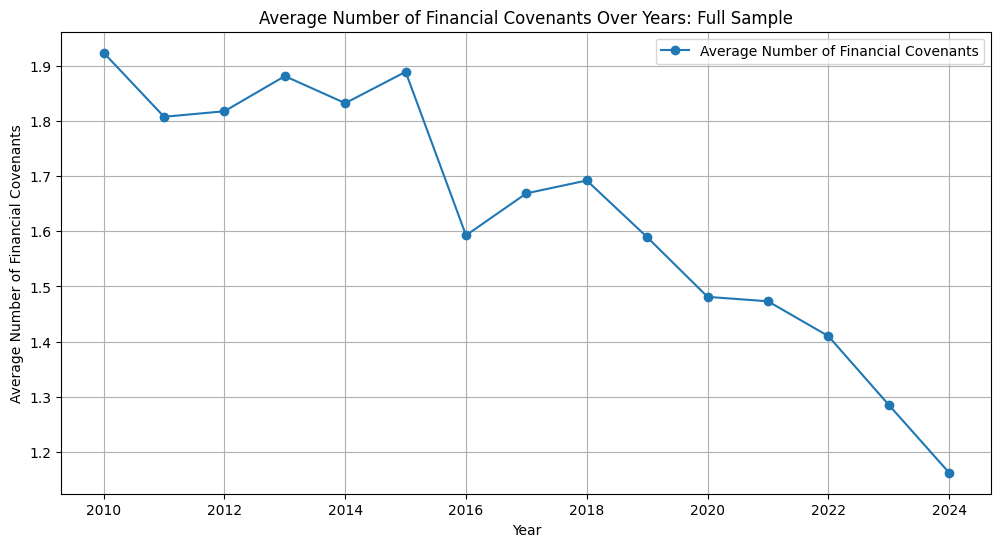

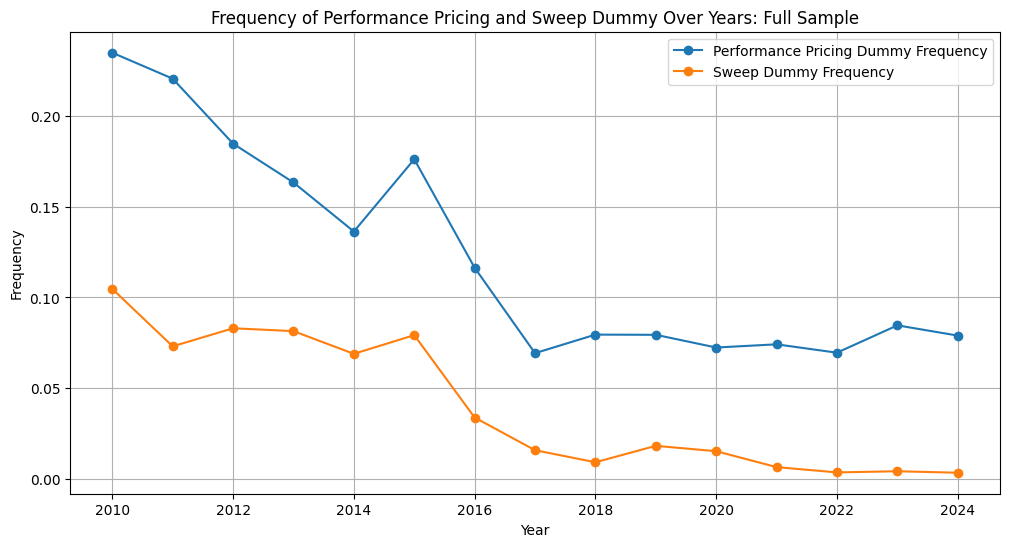

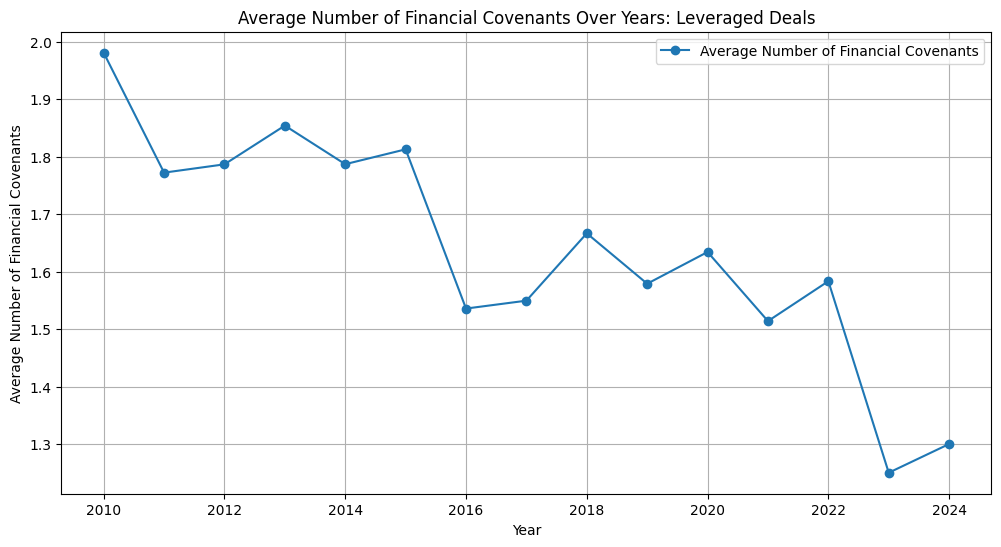

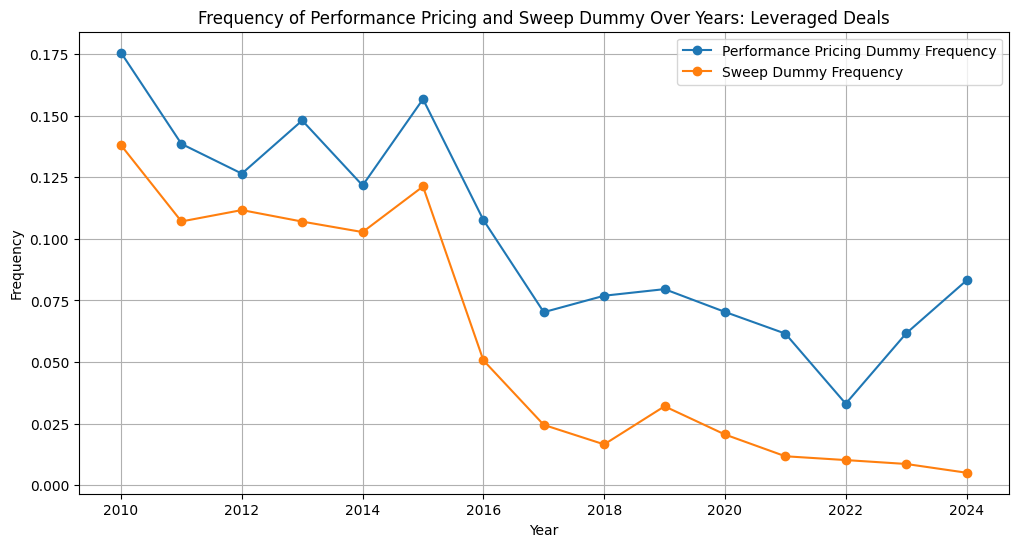

In [27]:
# Plot the average number of num_fin_cov over years
plt.figure(figsize=(12, 6))
plt.plot(avg_num_fin_cov['year'], avg_num_fin_cov['num_fin_cov'], marker='o', label='Average Number of Financial Covenants')
plt.xlabel('Year')
plt.ylabel('Average Number of Financial Covenants')
plt.title('Average Number of Financial Covenants Over Years: Full Sample')
plt.legend()
plt.grid(True)
# save as png
plt.savefig(os.path.join(overleaf_dir,'Figures/avg_num_fin_cov_fullsample.png'))

# Plot the frequency of perf_pricing_dummy and sweep_dummy over years
plt.figure(figsize=(12, 6))
plt.plot(freq_perf_pricing['year'], freq_perf_pricing['perf_pricing_dummy'], marker='o', label='Performance Pricing Dummy Frequency')
plt.plot(freq_sweep['year'], freq_sweep['sweep_dummy'], marker='o', label='Sweep Dummy Frequency')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of Performance Pricing and Sweep Dummy Over Years: Full Sample')
plt.legend()
plt.grid(True)
# save as png
plt.savefig(os.path.join(overleaf_dir,'Figures/freq_perf_pricing_sweep_fullsample.png'))

# keep only leveraged deals (leveraged = 1)
collapsed_ds_leveraged = collapsed_ds[collapsed_ds['leveraged'] == 1]
# Calculate the average number of num_fin_cov over years
avg_num_fin_cov = collapsed_ds_leveraged.groupby('year')['num_fin_cov'].mean().reset_index()
# Calculate the frequency of perf_pricing_dummy and sweep_dummy over years
freq_perf_pricing = collapsed_ds_leveraged.groupby('year')['perf_pricing_dummy'].mean().reset_index()
freq_sweep = collapsed_ds_leveraged.groupby('year')['sweep_dummy'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(avg_num_fin_cov['year'], avg_num_fin_cov['num_fin_cov'], marker='o', label='Average Number of Financial Covenants')
plt.xlabel('Year')
plt.ylabel('Average Number of Financial Covenants')
plt.title('Average Number of Financial Covenants Over Years: Leveraged Deals')
plt.legend()
plt.grid(True)
# save as png
plt.savefig(os.path.join(overleaf_dir,'Figures/avg_num_fin_cov_leveraged.png'))

# Plot the frequency of perf_pricing_dummy and sweep_dummy over years
plt.figure(figsize=(12, 6))
plt.plot(freq_perf_pricing['year'], freq_perf_pricing['perf_pricing_dummy'], marker='o', label='Performance Pricing Dummy Frequency')
plt.plot(freq_sweep['year'], freq_sweep['sweep_dummy'], marker='o', label='Sweep Dummy Frequency')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of Performance Pricing and Sweep Dummy Over Years: Leveraged Deals')
plt.legend()
plt.grid(True)
# save as png
plt.savefig(os.path.join(overleaf_dir,'Figures/freq_perf_pricing_sweep_leveraged.png'))

# Finalize DS-Compa Merged Data

In [28]:
# order by lpc_deal_id facilityid lpc_tranche_id packageid and sort by them
dealscan_comp_crspa_merged = dealscan_comp_crspa_merged.sort_values(['lpc_deal_id', 'facilityid', 'lpc_tranche_id', 'packageid'])
dealscan_comp_crspa_merged = dealscan_comp_crspa_merged.reset_index(drop=True)

# put lpc_deal_id facilityid lpc_tranche_id packageid tranchetype and deal_active_date in the first columns
dealscan_comp_crspa_merged = dealscan_comp_crspa_merged[['lpc_deal_id', 'facilityid', 'lpc_tranche_id', 'packageid', 'tranche_type', 'deal_active_date'] + 
                                              [col for col in dealscan_comp_crspa_merged.columns if col not in ['lpc_deal_id', 'facilityid', 'lpc_tranche_id', 'packageid', 'tranchetype', 'deal_active_date']]]

# collapse by lpc_tranche_id and keep only the first entry 
tranche_level_ds_compa = dealscan_comp_crspa_merged.groupby(['lpc_tranche_id']).agg({
    'lpc_deal_id': 'first',
    'packageid': 'first',
    'facilityid': 'first',
    'deal_permid': 'first',
    'deal_active_date': 'min',
    'gvkey': 'first',
    'borrower_name': 'first',
    'borrower_id': 'first',
    'state_province': 'first',
    'country': 'first',
    'zip': 'first',
    'city': 'first',
    'sic_code': 'first',
    'sponsor': 'first',
    'lead_arranger': 'first',
    'number_of_lenders': 'first',
    'deal_amount': 'first',
    'deal_amount_converted': 'first',
    'deal_purpose': 'first',
    'deal_amended': 'first',
    'market_segment': 'first',
    'seniority_type': 'first',
    'secured': 'first',
    'margin_bps': 'first',
    'leveraged': 'first',
    'fyear': 'first',
    'covenants': 'first', 
    'all_covenants_financial': 'first',
    'performance_pricing': 'first',
    'excess_cf_sweep': 'first',
    'asset_sales_sweep': 'first',
    'debt_issue_sweep': 'first',
    'equity_issue_sweep': 'first',
    'insurance_proceeds_sweep': 'first',
    'interest_expense_by_ebitda': 'first',
    'xint': 'first',
    'ebitda': 'first',
    'ebit': 'first',
    'at': 'first',
    'capx': 'first',
    'che': 'first',
    'oancf': 'first',
    'debt': 'first',
    'dlstcd': 'first',
    'dvc': 'first',
    'dividend_payer': 'first',
    'pi': 'first',
    'dp': 'first',
    'excess_interest_30': 'first',
    'excess_interest_loss': 'first',
    'financial_deficit': 'first',
    'immediate_depletion': 'first',
    'intan': 'first',
    'interest_expense_30_rule': 'first',
    'interest_expense_loss_rule': 'first',
    'interest_expense_not_excess': 'first',
    'interest_expense_total_excess': 'first',
    'idit': 'first',
    'investment': 'first',
    'loss_before_interest_expense': 'first',
    'market_to_book': 'first',
    'mnc': 'first',
    'net_interest': 'first',
    'nol': 'first',
    'ppent': 'first',
    'xrd': 'first',
    'sale': 'first',
    'sales_growth': 'first',
    'ret_buy_and_hold': 'first',
    'ret_vol': 'first',
    'z_score': 'first',
    'delta_dcf': 'first',
    'ipodate': 'first',
}).reset_index()

In [29]:
# generate num_fin_cov that is the number of commas in all_covenants_financial + 1
tranche_level_ds_compa['num_fin_cov'] = tranche_level_ds_compa['all_covenants_financial'].str.count(',') + 1
# generate perf_pricing dummy that is 1 if performance_pricing is not empty
tranche_level_ds_compa['perf_pricing_dummy'] = tranche_level_ds_compa['performance_pricing'].notnull().astype(int)
# generate sweep dummy that is 1 if any of the sweep covenants is not empty
sweep_cols = ['excess_cf_sweep', 'asset_sales_sweep', 'debt_issue_sweep', 'equity_issue_sweep', 'insurance_proceeds_sweep']
tranche_level_ds_compa['sweep_dummy'] = tranche_level_ds_compa[sweep_cols].notnull().any(axis=1).astype(int)

# Calculate the average number of num_fin_cov over years
avg_num_fin_cov = tranche_level_ds_compa.groupby('fyear')['num_fin_cov'].mean().reset_index()
# Calculate the frequency of perf_pricing_dummy and sweep_dummy over years
freq_perf_pricing = tranche_level_ds_compa.groupby('fyear')['perf_pricing_dummy'].mean().reset_index()
freq_sweep = tranche_level_ds_compa.groupby('fyear')['sweep_dummy'].mean().reset_index()

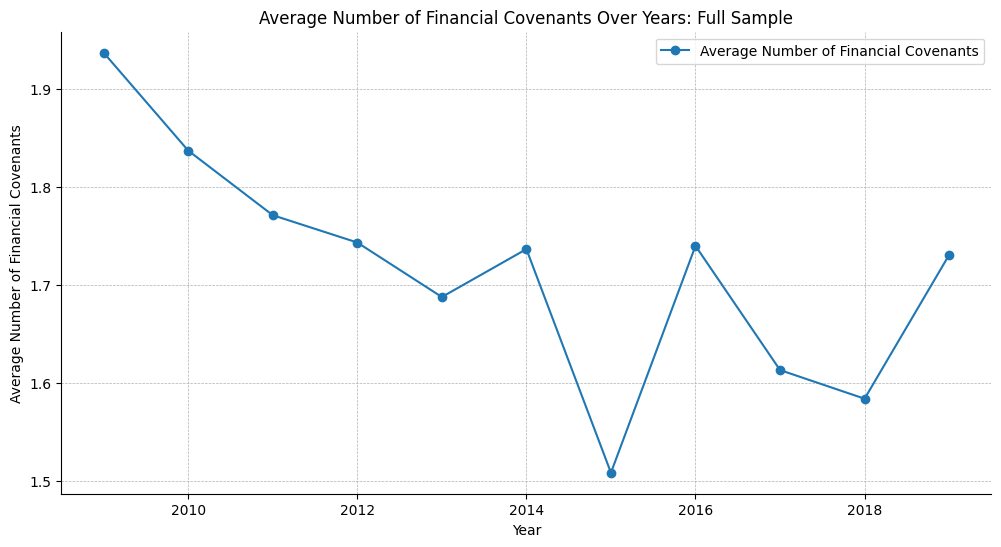

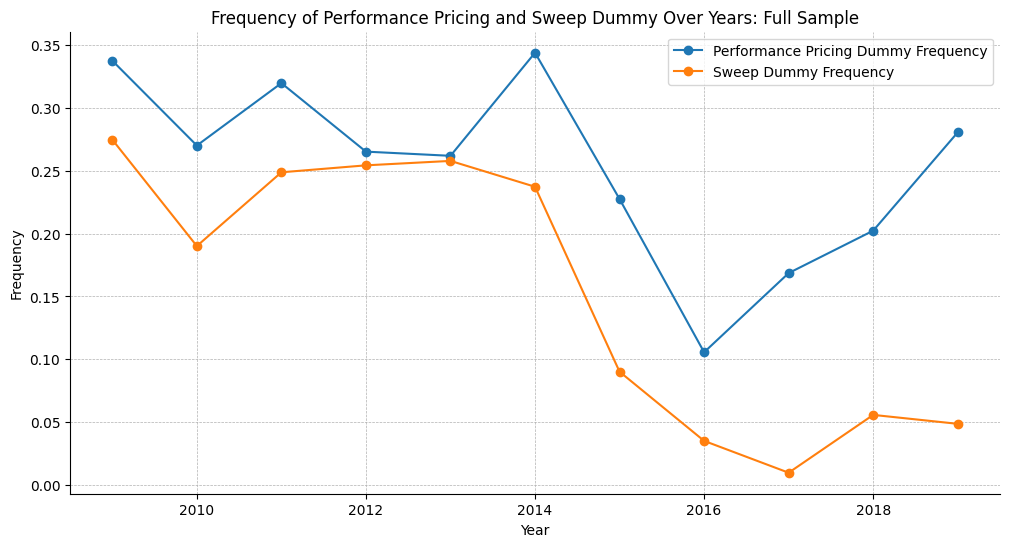

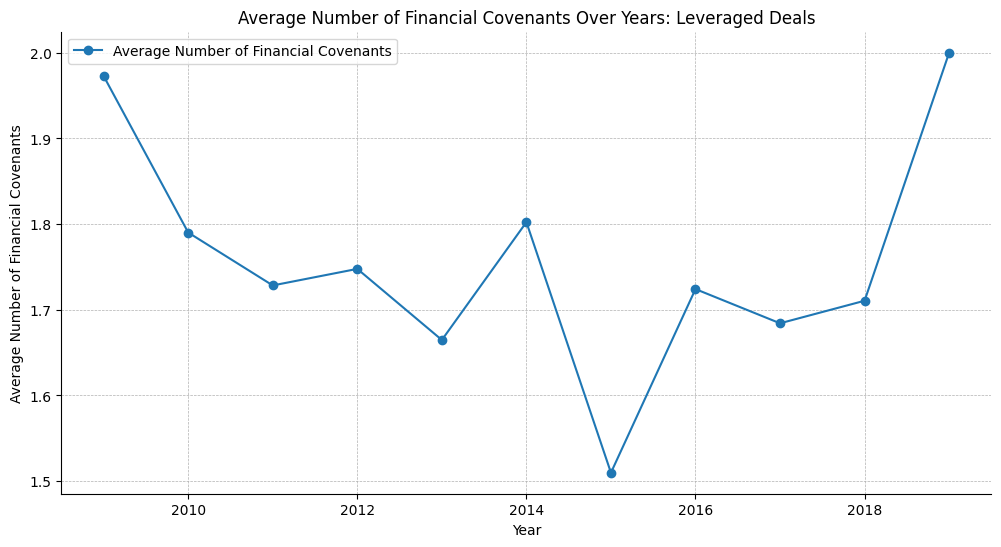

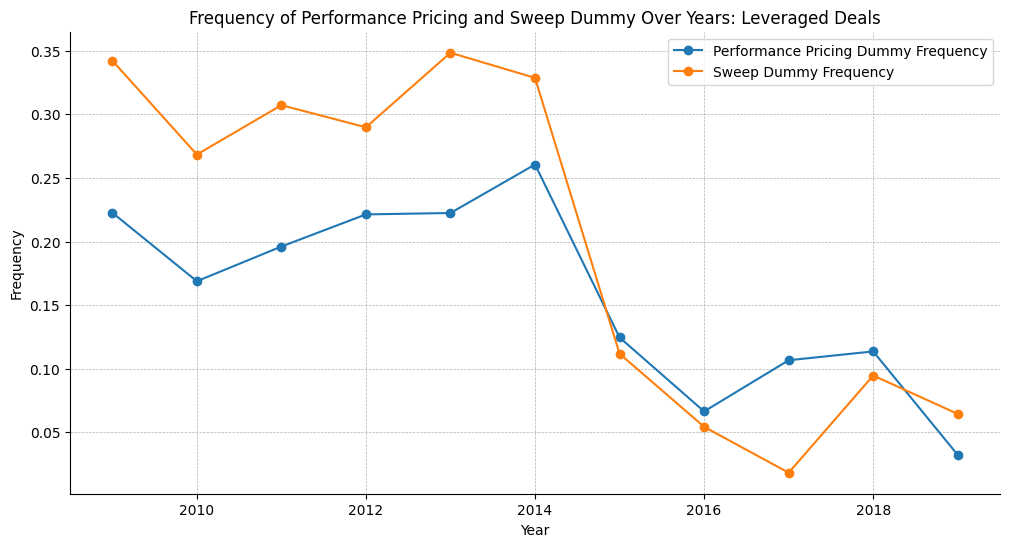

In [30]:
# Plot the average number of num_fin_cov over years
plt.figure(figsize=(12, 6))
plt.plot(avg_num_fin_cov['fyear'], avg_num_fin_cov['num_fin_cov'], marker='o', label='Average Number of Financial Covenants')
plt.xlabel('Year')
plt.ylabel('Average Number of Financial Covenants')
plt.title('Average Number of Financial Covenants Over Years: Full Sample')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
# save as png
plt.savefig(os.path.join(overleaf_dir,'Figures/avg_num_fin_cov_fullsample.png'))

# Plot the frequency of perf_pricing_dummy and sweep_dummy over years
plt.figure(figsize=(12, 6))
plt.plot(freq_perf_pricing['fyear'], freq_perf_pricing['perf_pricing_dummy'], marker='o', label='Performance Pricing Dummy Frequency')
plt.plot(freq_sweep['fyear'], freq_sweep['sweep_dummy'], marker='o', label='Sweep Dummy Frequency')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of Performance Pricing and Sweep Dummy Over Years: Full Sample')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
# save as png
plt.savefig(os.path.join(overleaf_dir,'Figures/freq_perf_pricing_sweep_fullsample.png'))

# keep only leveraged deals (leveraged = 1) and do the same plots
tranche_level_ds_compa_leveraged = tranche_level_ds_compa[tranche_level_ds_compa['leveraged'] == 1]

# Calculate the average number of num_fin_cov over years
avg_num_fin_cov = tranche_level_ds_compa_leveraged.groupby('fyear')['num_fin_cov'].mean().reset_index()
# Calculate the frequency of perf_pricing_dummy and sweep_dummy over years
freq_perf_pricing = tranche_level_ds_compa_leveraged.groupby('fyear')['perf_pricing_dummy'].mean().reset_index()
freq_sweep = tranche_level_ds_compa_leveraged.groupby('fyear')['sweep_dummy'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(avg_num_fin_cov['fyear'], avg_num_fin_cov['num_fin_cov'], marker='o', label='Average Number of Financial Covenants')
plt.xlabel('Year')
plt.ylabel('Average Number of Financial Covenants')
plt.title('Average Number of Financial Covenants Over Years: Leveraged Deals')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
# save as png
plt.savefig(os.path.join(overleaf_dir,'Figures/avg_num_fin_cov_leveraged.png'))

# Plot the frequency of perf_pricing_dummy and sweep_dummy over years
plt.figure(figsize=(12, 6))
plt.plot(freq_perf_pricing['fyear'], freq_perf_pricing['perf_pricing_dummy'], marker='o', label='Performance Pricing Dummy Frequency')
plt.plot(freq_sweep['fyear'], freq_sweep['sweep_dummy'], marker='o', label='Sweep Dummy Frequency')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of Performance Pricing and Sweep Dummy Over Years: Leveraged Deals')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
# save as png
plt.savefig(os.path.join(overleaf_dir,'Figures/freq_perf_pricing_sweep_leveraged.png'))


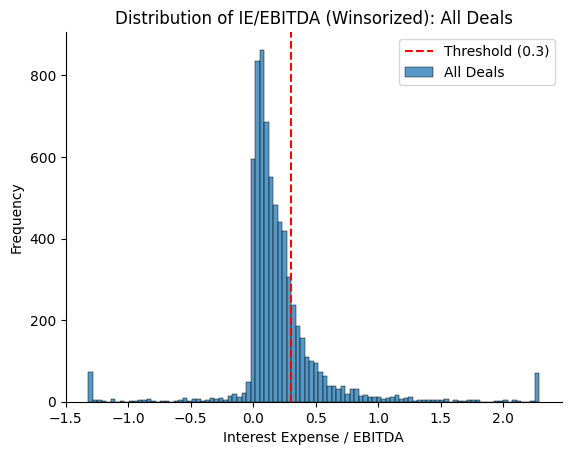

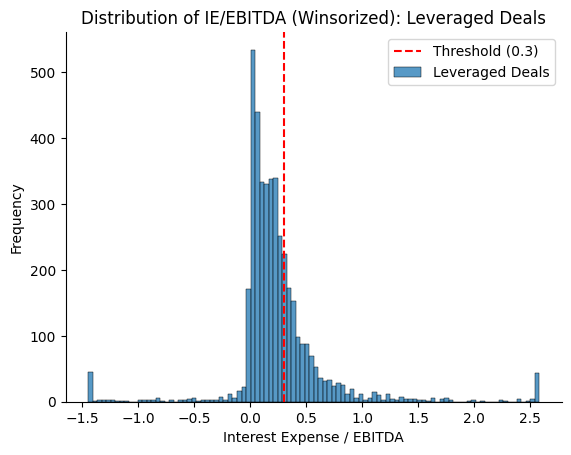

In [31]:
# plot the histogram of winsorized interest_expense_by_ebitda for all deals
interest_expense_winsorized = tranche_level_ds_compa['interest_expense_by_ebitda'].clip(tranche_level_ds_compa['interest_expense_by_ebitda'].quantile(0.01), tranche_level_ds_compa['interest_expense_by_ebitda'].quantile(0.99))
sns.histplot(interest_expense_winsorized, bins=100, label='All Deals')
plt.axvline(x=0.3, color='r', linestyle='--', label='Threshold (0.3)')
plt.xlabel('Interest Expense / EBITDA')
plt.ylabel('Frequency')
plt.title('Distribution of IE/EBITDA (Winsorized): All Deals')
plt.legend()
sns.despine()
plt.savefig(os.path.join(overleaf_dir, 'Figures/ie_ebitda_all_deals.png'))
plt.show()

# plot the histogram of winsorized interest_expense_by_ebitda for leveraged deals only
tranche_level_ds_compa_leveraged = tranche_level_ds_compa[tranche_level_ds_compa['leveraged'] == 1]
interest_expense_winsorized = tranche_level_ds_compa_leveraged['interest_expense_by_ebitda'].clip(tranche_level_ds_compa_leveraged['interest_expense_by_ebitda'].quantile(0.01), tranche_level_ds_compa_leveraged['interest_expense_by_ebitda'].quantile(0.99))
sns.histplot(interest_expense_winsorized, bins=100, label='Leveraged Deals')
plt.axvline(x=0.3, color='r', linestyle='--', label='Threshold (0.3)')
plt.xlabel('Interest Expense / EBITDA')
plt.ylabel('Frequency')
plt.title('Distribution of IE/EBITDA (Winsorized): Leveraged Deals')
plt.legend()
sns.despine()
plt.savefig(os.path.join(overleaf_dir, 'Figures/ie_ebitda_leveraged_deals.png'))
plt.show()

## Summary Statistics of Firms in the Sample

In [32]:
# Generate variables for the summary statistics

from tabulate import tabulate

# dlst_distress if dlstcd starts with 4 or 5
# dlst_distress if dlstcd starts with 4 or 5
tranche_level_ds_compa['dlst_distress'] = tranche_level_ds_compa['dlstcd'].astype(str).str.startswith(('4', '5')).astype(int)
# dlst_merger if dlstcd starts with 2 or 3
tranche_level_ds_compa['dlst_merger'] = tranche_level_ds_compa['dlstcd'].astype(str).str.startswith(('2', '3')).astype(int)

# interest_total = xint / at
tranche_level_ds_compa['interest_total'] = tranche_level_ds_compa['xint'] / tranche_level_ds_compa['at']
# interest_total_excess = interest_expense_total_excess / at
tranche_level_ds_compa['interest_total_excess'] = tranche_level_ds_compa['interest_expense_total_excess'] / tranche_level_ds_compa['at']
# interest_not_excess = interest_expense_not_excess / at
tranche_level_ds_compa['interest_not_excess'] = tranche_level_ds_compa['interest_expense_not_excess'] / tranche_level_ds_compa['at']
# interest_loss = interest_expense_loss_rule / at
tranche_level_ds_compa['interest_loss'] = tranche_level_ds_compa['interest_expense_loss_rule'] / tranche_level_ds_compa['at']
# interest_30 = interest_expense_30_rule / at
tranche_level_ds_compa['interest_30'] = tranche_level_ds_compa['interest_expense_30_rule'] / tranche_level_ds_compa['at']
# net interest < 0
tranche_level_ds_compa['net_interest_neg'] = (tranche_level_ds_compa['net_interest'] < 0).astype(int)
# net interest / EBITDA
tranche_level_ds_compa['net_interest_by_ebitda'] = tranche_level_ds_compa['net_interest'] / tranche_level_ds_compa['ebitda']
# net interest / EBIT
tranche_level_ds_compa['net_interest_by_ebit'] = tranche_level_ds_compa['net_interest'] / tranche_level_ds_compa['ebit']
# delta_dcf / at
tranche_level_ds_compa['delta_dcf_by_at'] = tranche_level_ds_compa['delta_dcf'] / tranche_level_ds_compa['at']
# delta_dcf / ebitda
tranche_level_ds_compa['delta_dcf_by_ebitda'] = tranche_level_ds_compa['delta_dcf'] / tranche_level_ds_compa['ebitda']
# debt / at
tranche_level_ds_compa['debt_by_at'] = tranche_level_ds_compa['debt'] / tranche_level_ds_compa['at']
# interest / debt
tranche_level_ds_compa['interest_by_debt'] = tranche_level_ds_compa['xint'] / tranche_level_ds_compa['debt']
# winsorize at 1% and 99%
# tranche_level_ds_compa['interest_by_debt'] = tranche_level_ds_compa['interest_by_debt'].clip(tranche_level_ds_compa['interest_by_debt'].quantile(0.01), tranche_level_ds_compa['interest_by_debt'].quantile(0.99))
tranche_level_ds_compa.replace([np.inf, -np.inf], np.nan, inplace=True)
# cash / at
tranche_level_ds_compa['cash_by_at'] = tranche_level_ds_compa['che'] / tranche_level_ds_compa['at']
# cash flows / at
tranche_level_ds_compa['cash_flows_by_at'] = tranche_level_ds_compa['oancf'] / tranche_level_ds_compa['at']
# ppent / at
tranche_level_ds_compa['ppent_by_at'] = tranche_level_ds_compa['ppent'] / tranche_level_ds_compa['at']
# total assets = at / 1000
tranche_level_ds_compa['total_asset'] = tranche_level_ds_compa['at'] / 1000

# Dictionary to map variable names to labels
variable_labels = {
    'excess_interest_30': 'Excess Interest (30% Rule)',
    'excess_interest_loss': 'Excess Interest (Loss Rule)',
    'loss_before_interest_expense': 'Loss Before Interest Expense',
    'interest_total': 'Interest Expense (Total) / Assets',
    'interest_not_excess': 'Interest Expense (Not Excess) / Assets',
    'interest_loss': 'Interest Expense (Excess Loss Rule) / Assets',
    'interest_30': 'Interest Expense (Excess 30% Rule) / Assets',
    'interest_total_excess': 'Interest Expense (Total Excess 30% Rule) / Assets',
    'net_interest_neg': 'Net Interest < 0',
    'net_interest_by_ebitda': 'Net Interest / EBITDA',
    'net_interest_by_ebit': 'Net Interest / EBIT',
    'delta_dcf_by_at': 'Net Debt Issues / Assets',
    'delta_dcf_by_ebitda': 'Net Debt Issues / EBITDA',
    'debt_by_at': 'Debt / Assets',
    'interest_by_debt': 'Interest Expense / Debt',
    'cash_by_at': 'Cash / Assets',
    'cash_flows_by_at': 'Cash Flows / Assets',
    'ppent_by_at': 'PP&E / Assets',
    'total_asset': 'Assets ($Billion)',
    'dividend_payer': 'Dividend Payer',
    'z_score': 'Z-Score',
    'sales_growth': 'Sales Growth',
    'nol': 'Net Operating Loss',
    'market_to_book': 'Market to Book Ratio',
    'ret_buy_and_hold': 'Buy and Hold Return',
    'ret_vol': 'Return Volatility',
    'financial_deficit': 'Financial Deficit',
    'immediate_depletion': 'Immediate Depletion',
    'mnc': 'Multinational Corporation',
}

# Calculate summary statistics for the variables in variable_labels
summary_stats_all = tranche_level_ds_compa[variable_labels.keys()].describe().transpose()

# Rename the index using the variable labels
summary_stats_all.rename(index=variable_labels, inplace=True)

# Convert to LaTeX table with specified number format and labels
summary_stats_all.columns = ['Count', 'Mean', 'Std. Dev.', 'Min', 'P25', 'Median', 'P75', 'Max']
latex_table = tabulate(summary_stats_all, headers="keys", tablefmt="latex", floatfmt=(".0f", ".0f", ".2f", ".2f", ".2f", ".2f", ".2f", ".2f", ".2f"))

# Modify \hline to \hline\hline right after \begin{tabular}{lrrrrrrrr}
latex_table = latex_table.replace("\\begin{tabular}{lrrrrrrrr}\n\\hline", "\\begin{tabular}{lrrrrrrrr}\n\\hline\\hline")

# Modify \hline to \hline\hline right before \end{tabular}
latex_table = latex_table.replace("\\hline\n\\end{tabular}", "\\hline\\hline\n\\end{tabular}")

# Print or save the LaTeX table
print(latex_table)
with open(os.path.join(overleaf_dir, 'Tables/summary_stats_all.tex'), 'w') as f:
    f.write(latex_table)


\begin{tabular}{lrrrrrrrr}
\hline\hline
                                                   &   Count &   Mean &   Std. Dev. &     Min &   P25 &   Median &   P75 &     Max \\
\hline
 Excess Interest (30\% Rule)                        &    6992 &   0.26 &        0.44 &    0.00 &  0.00 &     0.00 &  1.00 &    1.00 \\
 Excess Interest (Loss Rule)                       &    6992 &   0.23 &        0.42 &    0.00 &  0.00 &     0.00 &  0.00 &    1.00 \\
 Loss Before Interest Expense                      &    6992 &   0.23 &        0.42 &    0.00 &  0.00 &     0.00 &  0.00 &    1.00 \\
 Interest Expense (Total) / Assets                 &    6992 &   0.02 &        0.02 &    0.00 &  0.01 &     0.02 &  0.03 &    0.47 \\
 Interest Expense (Not Excess) / Assets            &    6992 &   0.01 &        0.01 &    0.00 &  0.00 &     0.01 &  0.02 &    0.13 \\
 Interest Expense (Excess Loss Rule) / Assets      &    6992 &   0.01 &        0.02 &    0.00 &  0.00 &     0.00 &  0.00 &    0.47 \\
 Interest Expe